In [1]:
!pip install spotipy
!pip install gradio
!pip install opencv-python
!pip install PyQt5
!pip install flask

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pickle
import os
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# 셀 2: 데이터셋 정의 + CNN 학습 및 저장  (ResNet50 기반 + 하이퍼파라미터 튜닝)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pickle
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# (1) Dataset 클래스 정의
class OSTImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        lbl = self.labels[idx]
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"⚠️ 이미지 로드 실패: {img_path} → {e}")
            img = Image.new("RGB", (224,224), (0,0,0))
        img = self.transform(img)
        return img, torch.tensor(lbl, dtype=torch.long)



In [5]:
label_encoder_path = "label_encoder.pkl"
cnn_model_path      = "cnn_model.pt"

if not os.path.exists(label_encoder_path):
    raise FileNotFoundError(f"라벨 인코더 파일이 없습니다: {label_encoder_path}")
if not os.path.exists(cnn_model_path):
    raise FileNotFoundError(f"CNN 모델 파일이 없습니다: {cnn_model_path}")

with open(label_encoder_path, "rb") as f:
    label_encoder = pickle.load(f)

# 디바이스 설정
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# CNN 모델 클래스 정의 (학습 시 사용한 것과 동일)
class CNNClassifier(nn.Module):
    def __init__(self, num_labels):
        super(CNNClassifier, self).__init__()
        self.backbone = models.resnet18(pretrained=False)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_labels)
    def forward(self, x):
        return self.backbone(x)

num_labels = len(label_encoder.classes_)
cnn_model = CNNClassifier(num_labels=num_labels).to(DEVICE)
cnn_model.load_state_dict(torch.load(cnn_model_path, map_location=DEVICE))
cnn_model.eval()


/opt/anaconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/gb/k2ch9y591d5bw7hnyyhq8zfr0000gn/T/ipykernel_22327/3063405111.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default

CNNClassifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [6]:
# (2) 레이블 인코더 로드
label_encoder_path = "label_encoder.pkl"
with open(label_encoder_path, "rb") as f:
    label_encoder = pickle.load(f)
num_labels = len(label_encoder.classes_)


In [7]:
# (3) 데이터 준비
image_dir = "video_frames2"
all_paths, all_labels = [], []
for lbl_name in label_encoder.classes_:
    lbl_idx = int(label_encoder.transform([lbl_name])[0])
    subdir = os.path.join(image_dir, str(lbl_idx))
    if not os.path.isdir(subdir): continue
    for fname in os.listdir(subdir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            path = os.path.join(subdir, fname)
            all_paths.append(path)
            all_labels.append(lbl_idx)
print(f"✅ 총 이미지: {len(all_paths)}")



✅ 총 이미지: 1056


In [8]:
# (4) 학습/검증 분리
train_paths, val_paths, train_lbls, val_lbls = train_test_split(
    all_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)


In [9]:
# (5) 전처리 + 증강 정의
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [10]:
# (6) DataLoader 생성
batch_size = 32
train_ds = OSTImageDataset(train_paths, train_lbls, train_transform)
val_ds   = OSTImageDataset(val_paths,   val_lbls,   val_transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [11]:
# (7) ResNet50 기반 모델 정의
class CNNClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(self.backbone.fc.in_features, num_labels)
        )
    def forward(self, x):
        return self.backbone(x)

# (8) 디바이스 설정 및 모델 초기화
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNClassifier(num_labels=num_labels).to(DEVICE)

# (9) 손실함수, 옵티마이저, 스케줄러 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


/opt/anaconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/jungwoong-jeon/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:10<00:00, 9.85MB/s]
/opt/anaconda3/envs/py312/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please u

In [12]:
# (10) 학습/검증 함수 정의

def train_and_validate(model, train_loader, val_loader, epochs=20):
    train_losses, val_losses = [], []
    train_accs,  val_accs   = [], []
    for epoch in range(1, epochs+1):
        # 학습 단계
        model.train()
        total_loss, total_correct, total = 0,0,0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            preds = outputs.argmax(dim=1)
            total_correct += (preds==lbls).sum().item()
            total += lbls.size(0)
            total_loss += loss.item()*lbls.size(0)
        epoch_train_loss = total_loss/total
        epoch_train_acc  = total_correct/total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # 검증 단계
        model.eval()
        v_loss, v_correct, v_total = 0,0,0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, lbls)
                preds = outputs.argmax(dim=1)
                v_correct += (preds==lbls).sum().item()
                v_total += lbls.size(0)
                v_loss += loss.item()*lbls.size(0)
        epoch_val_loss = v_loss/v_total
        epoch_val_acc  = v_correct/v_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        # LR 스케줄러
        scheduler.step(epoch_val_loss)
        
        print(f"[Epoch {epoch}/{epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

    # (11) 모델 저장
    torch.save(model.state_dict(), "cnn_model_res50.pt")
    print("✅ ResNet50 기반 CNN 학습 완료 및 cnn_model_res50.pt 저장됨")
    
    # (12) 그래프
    epochs_range = range(1, epochs+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses,   label='Val Loss')
    plt.title('CNN Loss Curve')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_accs,  label='Train Acc')
    plt.plot(epochs_range, val_accs,    label='Val Acc')
    plt.title('CNN Accuracy Curve')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    plt.tight_layout()
    plt.show()



[Epoch 1/20] Train Loss: 1.4761, Acc: 0.5308 | Val Loss: 5.9609, Acc: 0.3538
[Epoch 2/20] Train Loss: 1.0903, Acc: 0.6291 | Val Loss: 1.2678, Acc: 0.5896
[Epoch 3/20] Train Loss: 0.8096, Acc: 0.6848 | Val Loss: 1.2093, Acc: 0.6179
[Epoch 4/20] Train Loss: 0.7028, Acc: 0.7334 | Val Loss: 2.8819, Acc: 0.3160
[Epoch 5/20] Train Loss: 0.6778, Acc: 0.7512 | Val Loss: 2.1947, Acc: 0.4623
[Epoch 6/20] Train Loss: 0.5960, Acc: 0.7666 | Val Loss: 1.3016, Acc: 0.5755
[Epoch 7/20] Train Loss: 0.4686, Acc: 0.8033 | Val Loss: 1.6167, Acc: 0.5708
[Epoch 8/20] Train Loss: 0.3780, Acc: 0.8436 | Val Loss: 0.8639, Acc: 0.6840
[Epoch 9/20] Train Loss: 0.3042, Acc: 0.8756 | Val Loss: 0.5621, Acc: 0.7783
[Epoch 10/20] Train Loss: 0.2587, Acc: 0.8614 | Val Loss: 0.7839, Acc: 0.6840
[Epoch 11/20] Train Loss: 0.2246, Acc: 0.8851 | Val Loss: 0.5884, Acc: 0.7406
[Epoch 12/20] Train Loss: 0.2255, Acc: 0.8791 | Val Loss: 0.5784, Acc: 0.7642
[Epoch 13/20] Train Loss: 0.2659, Acc: 0.8661 | Val Loss: 0.9285, Acc: 0.

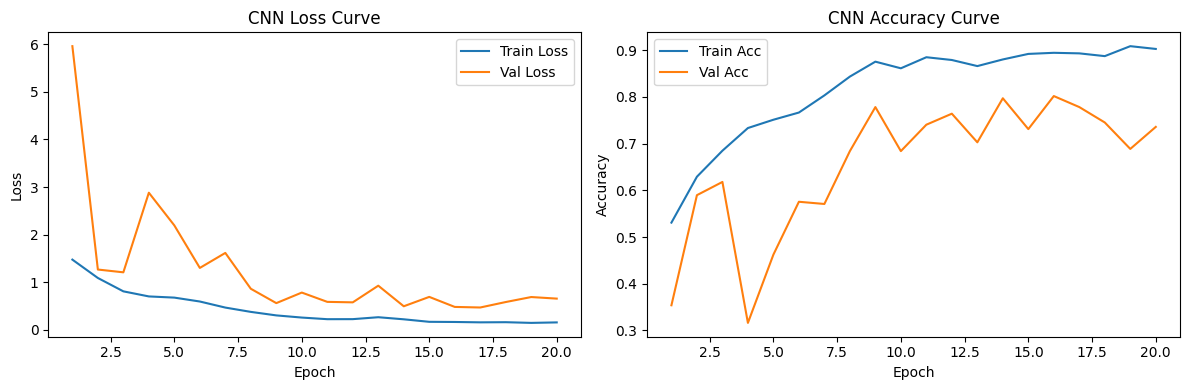

In [13]:
# (13) 학습 실행
train_and_validate(model, train_loader, val_loader, epochs=20)